import libraries

In [3]:
from dtocs import *
from helper import *
from maps import *
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal, osr
from lazy import lazy


In [4]:
class GDALInterface(object):
    SEA_LEVEL = 0
    def __init__(self, tif_path):
        super(GDALInterface, self).__init__()
        self.tif_path = tif_path
        self.loadMetadata()

    def get_corner_coords(self):
        ulx, xres, xskew, uly, yskew, yres = self.geo_transform
        lrx = ulx + (self.src.RasterXSize * xres)
        lry = uly + (self.src.RasterYSize * yres)
        return {
            'TOP_LEFT': (ulx, uly),
            'TOP_RIGHT': (lrx, uly),
            'BOTTOM_LEFT': (ulx, lry),
            'BOTTOM_RIGHT': (lrx, lry),
        }

    def loadMetadata(self):
        # open the raster and its spatial reference
        self.src = gdal.Open(self.tif_path)

        if self.src is None:
            raise Exception('Could not load GDAL file "%s"' % self.tif_path)
        spatial_reference_raster = osr.SpatialReference(self.src.GetProjection())

        # get the WGS84 spatial reference
        spatial_reference = osr.SpatialReference()
        spatial_reference.ImportFromEPSG(4326)  # WGS84

        # coordinate transformation
        self.coordinate_transform = osr.CoordinateTransformation(spatial_reference, spatial_reference_raster)
        gt = self.geo_transform = self.src.GetGeoTransform()
        dev = (gt[1] * gt[5] - gt[2] * gt[4])
        self.geo_transform_inv = (gt[0], gt[5] / dev, -gt[2] / dev,
                                  gt[3], -gt[4] / dev, gt[1] / dev)


    @lazy
    def points_array(self):
        b = self.src.GetRasterBand(1)
        return b.ReadAsArray()

    def print_statistics(self):
        print(self.src.GetRasterBand(1).GetStatistics(True, True))


    def lookup(self, lat, lon):
        try:

            # get coordinate of the raster
            xgeo, ygeo, zgeo = self.coordinate_transform.TransformPoint(lon, lat, 0)

            # convert it to pixel/line on band
            u = xgeo - self.geo_transform_inv[0]
            v = ygeo - self.geo_transform_inv[3]
            # FIXME this int() is probably bad idea, there should be half cell size thing needed
            xpix = int(self.geo_transform_inv[1] * u + self.geo_transform_inv[2] * v)
            ylin = int(self.geo_transform_inv[4] * u + self.geo_transform_inv[5] * v)

            # look the value up
            v = self.points_array[ylin, xpix]

            return v if v != -32768 else self.SEA_LEVEL
        except Exception as e:
            print(e)
            return self.SEA_LEVEL

    def close(self):
        self.src = None

    def __enter__(self):
        return self

    def __exit__(self, type, value, traceback):
        self.close()

bounding box

In [5]:
# USA random mountain
# lon1, lat1 = -109.83007049344715, 44.36470033197011
# lon2, lat2 = -109.7513685303535, 44.29673563882564

# India
# lon1, lat1 = 77.28112208857522,32.135432817449384
# lon2, lat2 = 77.62169826045022,31.94918029751246

# Colorado [Whole region]
# lon1, lat1 = -106.72643114729188,38.84785651131714
# lon2, lat2 = -105.95392348402243,39.458493653253676

# Colorado (peak to peak example)
lat1, lon1 = 38.94374018363843, -106.5759101561709
lat2, lon2 = 39.04527792014898, -106.38578062842298
resolution = 30
elevation_dataset_file = "/Users/aakash/Desktop/MTP/open-elevation-mod/data/elevation_dataset.tif"
landcover_dataset_file = "/Users/aakash/Desktop/MTP/open-elevation-mod/landcover/landcover_dataset.tif"

files = ["/Users/aakash/Desktop/MTP/open-elevation-mod/data/download_data.tif","/Users/aakash/Desktop/MTP/open-elevation-mod/data/data_us.tif","/Users/aakash/Desktop/MTP/open-elevation-mod/data/elevation_dataset.tif"]



In [6]:
elevation_dataset = GDALInterface(files[2])
landcover_dataset = GDALInterface(landcover_dataset_file)

Elevation matrix

In [8]:
elevation_map, landcover_map = getGrayLevelMatrix(lon1, lat1, lon2, lat2, resolution)

start:  39.04527792014898 -106.5759101561709
end:  38.94374018363843 -106.38578062842298
shape:  377 548


In [7]:
elevation_map, landcover_map = getGrayLevelMatrixFromDataSet(lon1, lat1, lon2, lat2, elevation_dataset, landcover_dataset, resolution)

start:  39.04527792014898 -106.5759101561709
end:  38.94374018363843 -106.38578062842298
shape:  377 548


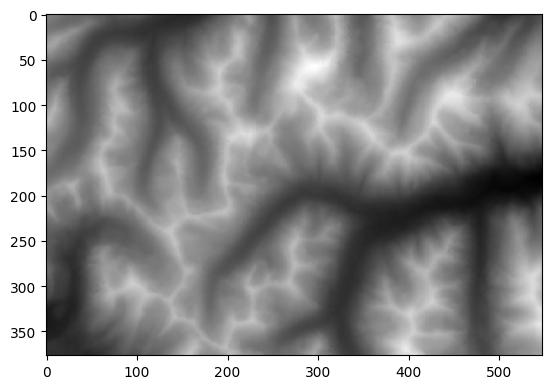

In [8]:
plt.imshow(elevation_map,cmap='gray')
plt.show()

In [9]:
print("Elevation Map Info")
print(f"Gray Map Shape: {elevation_map.shape}")
print(f"Min: {elevation_map.min()}")
print(f"Max: {elevation_map.max()}")

Elevation Map Info
Gray Map Shape: (377, 548)
Min: 2964
Max: 4362


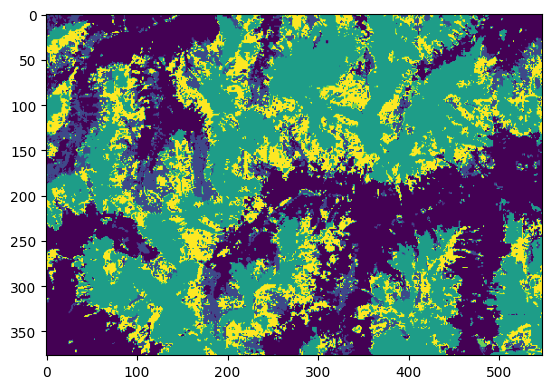

In [10]:
plt.imshow(landcover_map)
plt.show()

Source and Destination

In [11]:
n,m = elevation_map.shape

# USA random
# src_lon,src_lat = -109.81884898177093,44.32480359458633
# des_lon,des_lat = -109.77537406272984,44.30294042398075

src_lat, src_lon = 38.98065379328955, -106.528761396495
des_lat, des_lon = 39.02089538747208, -106.42163602957328

src_latIdx,src_lonIdx = findIndex(src_lat,src_lon, lat1,lon1, lat2,lon2, resolution)
des_latIdx,des_lonIdx = findIndex(des_lat,des_lon, lat1,lon1, lat2,lon2, resolution)

Dijkstra

In [12]:
# from dijkstra import dijkstraFromSrc, dijkstraFromSrcWithLC, showPathDijkstra
from dijkstra import dijkstraFromSrc, showPathDijkstra

In [13]:
alpha = 0
# distFromSrc, parentMat  = dijkstraFromSrc(elevation_map, src_latIdx, src_lonIdx, resolution)
distFromSrc, parentMat  = dijkstraFromSrc(elevation_map, landcover_map, src_latIdx, src_lonIdx, resolution, alpha)

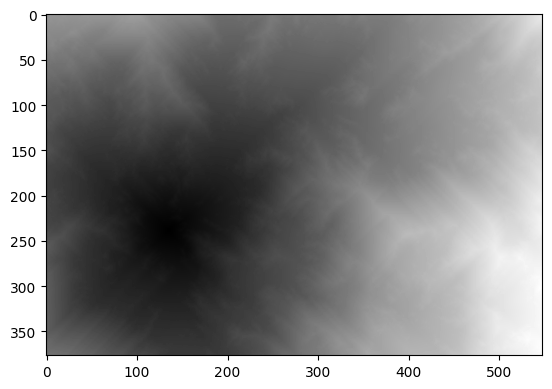

In [14]:
plt.imshow(distFromSrc,cmap='gray')
plt.show()

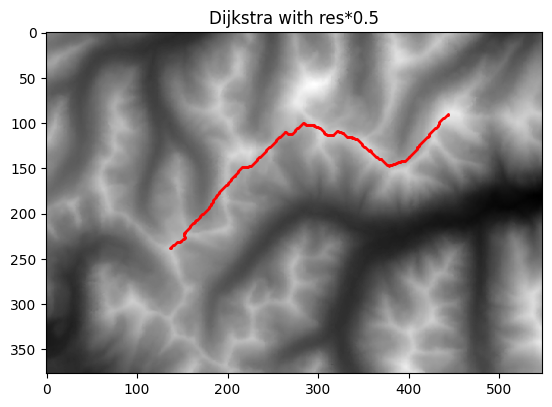

In [15]:
# elevation_map_copy=deepcopy(elevation_map)
showPathDijkstra(elevation_map, parentMat, src_latIdx, src_lonIdx, des_latIdx, des_lonIdx,h_weight = 0.5)

DTOCS Single Image

In [8]:
bin_map_start = initBinMap(src_latIdx, src_lonIdx, n, m)   
bin_map_end = initBinMap(des_latIdx, des_lonIdx, n, m)

In [9]:
accuracy = 0.0001
alpha = 0
parentMat = applyDistTfSingleSource(elevation_map, landcover_map, bin_map_start, accuracy, alpha)

Applying Distance transform......
Number of Passes for convergence: 4
Done!


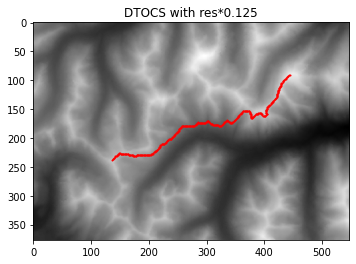

In [10]:
showPathDTCOS(elevation_map, parentMat, src_latIdx, src_lonIdx, des_latIdx, des_lonIdx)